In [1]:
import itertools
import functools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def combinations(x, degree):
    return itertools.combinations_with_replacement(x, degree)

In [3]:
def compute_new_features(items):
    return functools.reduce(lambda x, y: x * y, items)

In [4]:
def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]

    features = [np.ones(len(x))] #a list of np-arrays with all 1.

    for degree in range(1, degree + 1):
        for item in combinations(x.T, degree):
            features.append(compute_new_features(item))
            
    return np.asarray(features).T

In [5]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1,2) - 1
    x1 = np.random.normal(size=50).reshape(-1,2) + 1
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1,2) + np.array([5., 10.])
        return np.concatenate((x0, x1, x_1)), np.concatenate((np.zeros(25), np.ones(30))).astype(int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1,2) + 2
        return np.concatenate((x0, x1, x2)), np.concatenate((np.zeros(25), np.ones(25), 2 + np.zeros(25))).astype(int)
    return np.concatenate((x0, x1)), np.concatenate((np.zeros(25), np.ones(25))).astype(int)

https://github.com/ctgk/PRML/blob/8f8270cbae986c607f3cc6f89afefd58fa69fadd/prml/preprocess/label_transformer.py

In [6]:
class LabelTransformer(object):
    def __init__(self, n_classes:int=None):
        self.n_classes = n_classes

    @property
    def n_classes(self):
        return self.__n_classes

    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)
    @property
    def encoder(self):
        return self.__encoder

    def encode(self, class_indices:np.ndarray):
        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1

        return self.encoder[class_indices]

    def decode(self, onehot:np.ndarray):
        return np.argmax(onehot, axis=1)

In [7]:
# Testing LabelTranformer
l = LabelTransformer(2)
print(l.n_classes)
print(l.encoder[[0,1,0,1]])

2
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [8]:
LabelTransformer(2).encode(np.array([0,1,0,1]))

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [9]:
def preprocess(add_class=False, add_outliers=False, degree=1):
    x, y = create_toy_data(add_outliers, add_class)
    x_poly = polynomial_transform(x, degree=degree)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y) 
    y_train_trans = LabelTransformer().encode(y_train)
    y_test_trans = LabelTransformer().encode(y_test)
    return x_train , x_test, y_train, y_test, y_train_trans, y_test_trans 

In [10]:
x_train , x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess()

In [11]:
assert x_train.shape[0] == y_train.shape[0], "Not enough labels for all training samples"

In [12]:
assert x_test.shape[0] == y_test.shape[0], "Not enough labels for all test samples"

In [13]:
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(X_train, labels, lsc, degree=1):
#     sns.set_style("white")
    f = plt.figure(figsize=(8,8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.min(x_train[:,2])
    
    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100)) 
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc.predict(x_test_poly)
    
    sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.gca().set_aspect('equal', adjustable='box')

In [14]:
import numpy as np
class LeastSquareClassification(object): 
  def __init__(self): 
    self.t0 = 20 
    self.t1 = 1000
  
  def predict(self, X):
    return np.argmax( X @ self.w, axis=1)

  def loss(self, X,y, reg_rate):
    e = y - self.predict(X) 
    return (1/2)* (e.T @ e) + (reg_rate / 2) * (self.w).T @ (self.w)

  def predict_internal (self, x): 
     return X@self.w  
  
  def rmse(self, X, y):
    return np.sqrt(2 / X.shape[0] * self.loss(X,y,0))

  def fit(self, X, y,reg_rate):
    eye = np.eye(X.shape[1])
    self.w = np.linalg.solve(
        reg_rate * eye + X.T @ X, X.T @ y
    )
    return self.w

  def calculate_gradient(self,X, y,reg_rate):
    grad = X.T @  (self.predict(X) - y) + reg_rate * self.w
    return  grad

  def update_weight(self, grad, lr):
    returns (self.w - lr * grad)

  def learning_schedule(self, t):
     return self.t0 / (t + self.t1) 

  def gd(self, X, y, num_epochs, lr, reg_rate):
    self.w = np.zeros(X.shape[1])
    self.w_all = [] 
    self.err_all = [] 
    for i in np.arange(0, num_epochs):
      djdw = self.calculate_gradient(X, y, reg_rate)
      self.w_all.append(w)
      self.err_all.append(self.loss(X, y, reg_rate))
      self.w = self.update_weights(djdw, lr) 
    return self.w

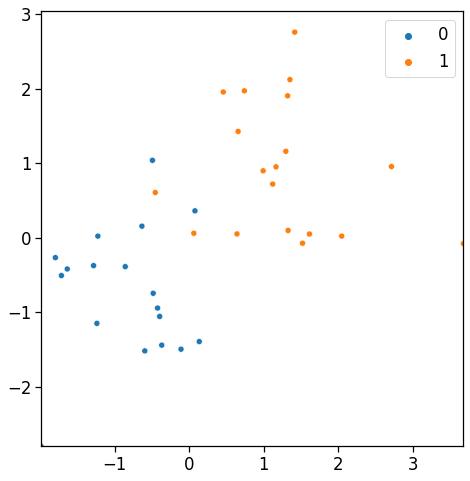

In [15]:
lsc = LeastSquareClassification()
lsc.fit(x_train, y_train_trans, reg_rate=0)
visualize_model(x_train, y_train, lsc)